# Dataloader Construct

In [1]:
# pillow 读取图片更快

import cv2
print("opencv spent time:")
%timeit -r 5 -n 1000 cv2.imread('./data/horse2zebra/trainA/n02381460_1001.jpg')

print("-------------------------")

print("pillow spent time:")
from PIL import Image
%timeit -r 5 -n 1000 Image.open('./data/horse2zebra/trainA/n02381460_1001.jpg')

opencv spent time:
1.04 ms ± 116 ns per loop (mean ± std. dev. of 5 runs, 1000 loops each)
-------------------------
pillow spent time:
59.9 µs ± 1.61 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


In [2]:
# dataset
import numpy as np
import random
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import transforms, Compose

def __flip(img: Image):
    return img.transpose(Image.FLIP_LEFT_RIGHT)
    
def data_transform(img, output_size=224, center_crop=True, convert=True):
    h, w, = img.size
    assert h == w and h >= output_size , "check picture size"
    transform_list = []
    
    if center_crop:
        transform_list.append(transforms.CenterCrop(output_size))
    else:
        transform_list.append(transforms.RandomCrop(output_size))
    
    # transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
    if random.random() > 0.5:
        transform_list.append(transforms.Lambda(lambda img: __flip(img)))
    
    if convert:
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5)))
    
    return transforms.Compose(transform_list)(img)

class A2BDateset(Dataset):
    def __init__(self, data_dir):
        super(A2BDateset, self).__init__()
        self.data_dir = data_dir
        self.pic_list_a = np.loadtxt(data_dir+'trainA.txt', dtype=str)
        np.random.shuffle(self.pic_list_a)
        self.pic_list_b = np.loadtxt(data_dir+'trainB.txt', dtype=str)
        np.random.shuffle(self.pic_list_b)
        self.pic_list_lenth = min(int(self.pic_list_a.shape[0]), int(self.pic_list_b.shape[0]))
    
    def __len__(self):
        return self.pic_list_lenth
    
    def __getitem__(self, idx):
        # Image A
        img_dir_a = self.data_dir+self.pic_list_a[idx]
        img_a = Image.open(img_dir_a).convert('RGB')
        img_a = data_transform(img_a, 224)
        
        # Image B
        img_dir_b = self.data_dir+self.pic_list_b[idx]
        img_b = Image.open(img_dir_b).convert('RGB')
        img_b = data_transform(img_b, 224)
        
        return {"A": img_a, "B": img_b, "img_dir_a": img_dir_a, "img_dir_b": img_dir_b}
        

In [3]:
BATCH_SIZE = 1
data_dir = './data/horse2zebra/' # 设置训练集数据地址
dataset = A2BDateset(data_dir)
dataset_size = len(dataset)  
dataset_size

1067

In [4]:
import torch
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

In [5]:
for i, data in enumerate(dataloader):
    print(f'step: {i+1}, data: {data}')
    break

step: 1, data: {'A': tensor([[[[-0.2941, -0.3725, -0.1765,  ..., -0.1608, -0.3490, -0.3882],
          [-0.3647, -0.3882,  0.0353,  ..., -0.2078, -0.3176, -0.3804],
          [-0.3647, -0.2706, -0.3569,  ..., -0.2627, -0.3412, -0.4196],
          ...,
          [-0.7255, -0.6706, -0.3804,  ...,  0.1765,  0.1373, -0.0118],
          [-0.5137, -0.2157, -0.0353,  ...,  0.0275,  0.0275,  0.0431],
          [ 0.0431,  0.0667, -0.4980,  ...,  0.1059,  0.0667,  0.2314]],

         [[-0.1686, -0.3020, -0.1373,  ..., -0.0039, -0.1765, -0.2314],
          [-0.2392, -0.3020,  0.1059,  ..., -0.0588, -0.1529, -0.2314],
          [-0.2549, -0.1922, -0.3020,  ..., -0.1137, -0.1843, -0.2784],
          ...,
          [-0.7255, -0.6157, -0.2549,  ...,  0.2392,  0.2471,  0.1529],
          [-0.5137, -0.1451,  0.1059,  ...,  0.0196,  0.0588,  0.1294],
          [ 0.0196,  0.0824, -0.4902,  ...,  0.1216,  0.0510,  0.1843]],

         [[-0.2706, -0.3412, -0.3882,  ..., -0.2784, -0.4588, -0.4431],
         

In [6]:
# 显示图片
import matplotlib.pyplot as plt
def show_pics(pics):
    """
    pics: List(Tensor[C, H, W])
    """
    plt.figure(figsize=(5 * len(pics), 5), dpi=80)
    for i in range(len(pics)):
        pics[i] = (pics[i][0].permute((1,2,0)) + 1) / 2
        plt.subplot(1, len(pics), i + 1)
        plt.imshow(pics[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

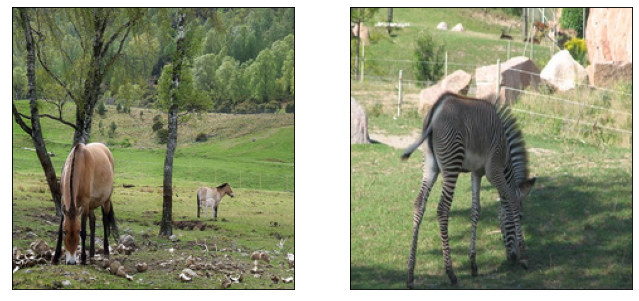

In [7]:
show_pics([data['A'], data['B']])

In [13]:
# BatchNorm or InstanceNorm
def get_norm_layer(norm_type='instance'):
    """Return a normalization layer

    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none

    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

In [14]:
# 初始化网络参数
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                torch.nn.init.normal_(m.weight.data, 0.0, std=init_gain)
            elif init_type == 'xavier':
                torch.nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                torch.nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, std=init_gain)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>

In [15]:
from torch import nn
import functools

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


initialize network with normal
生成器 out shape: torch.Size([1, 3, 224, 224])


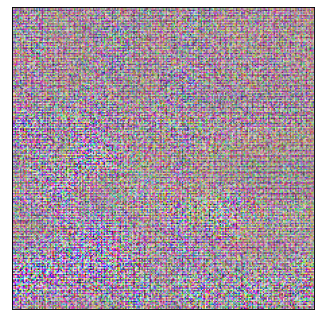

In [18]:
norm_layer = get_norm_layer(norm_type='instance')
g = ResnetGenerator(3, 3, n_blocks=9, norm_layer=norm_layer, use_dropout=True)
init_weights(g)

g.eval()
logit = g(data['A'])

print("生成器 out shape:", logit.shape)
show_pics([logit.detach().cpu()])

In [19]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


In [20]:
# PatchGan disc
d = NLayerDiscriminator(3, ndf=64, n_layers=3, norm_layer=norm_layer)
init_weights(d)
d.eval()
logit = d(data['A'])
print('判别器输出的特征图形状：', logit.shape)

initialize network with normal
判别器输出的特征图形状： torch.Size([1, 1, 26, 26])


In [21]:
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


/root/miniconda3/envs/jia/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


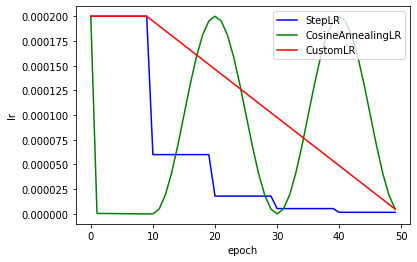

In [22]:
import itertools
# 学习率变化策略
epoch_count=1
n_epochs=10
n_epochs_decay=40

opt = torch.optim.Adam(itertools.chain(g.parameters(), d.parameters()), lr=0.0002, betas=(0.5, 0.999))

scheduler01 = torch.optim.lr_scheduler.StepLR(opt, step_size=n_epochs, gamma=0.3)

scheduler02 = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0, verbose=False)

def lambda_rule(epoch):
    lr_ratio = 1 - max(0, (epoch+epoch_count-n_epochs)/float(n_epochs_decay+1))
    return lr_ratio
scheduler03 = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda_rule)


x = list(range(n_epochs+n_epochs_decay))
y1 = []
y2 = []
y3 = []

for i in range(len(x)):
    y1.append(scheduler01.get_last_lr()[0])
    scheduler01.step()

for i in range(len(x)):
    y2.append(scheduler02.get_last_lr()[0])
    scheduler02.step()
    
for i in range(len(x)):
    y3.append(scheduler03.get_last_lr()[0])
    scheduler03.step()
    
plt.figure()   
plt.plot(x, y1, c='b', label='StepLR')
plt.plot(x, y2, c='g', label='CosineAnnealingLR')
plt.plot(x, y3, c='r', label='CustomLR')
plt.xlabel('epoch')
plt.ylabel('lr')
plt.legend(loc='upper right')


# Training

In [23]:
import itertools
import time
from torch.optim import lr_scheduler

# 冻结不需要的梯度
def set_requires_grad(nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

# 模型训练函数
def train(device,
          epoch_count=1,          # 训练其实的轮数
          n_epochs=100,           # 使用初始化 lr 的轮数, 见自定义调整学习率 lambda_rule 函数
          n_epochs_decay=100,     # lr 衰减到 0 的轮数, 见自定义调整学习率  lambda_rule 函数
          print_freq=10000,         # 间隔 step 打印 loss
          batch_size=1,
          max_step=200000,         # 训练最大 step 数
          model_path='pytorch/model/'
         ):

    # 定义两对生成器、判别器对象
    norm_layer = get_norm_layer(norm_type='instance')
    g_a = ResnetGenerator(3, 3, n_blocks=9, norm_layer=norm_layer, use_dropout=True) # G:   x -> Y^ / X^ -> y^
    g_b = ResnetGenerator(3, 3, n_blocks=9, norm_layer=norm_layer, use_dropout=True) # F:   y -> X^ / Y^ -> x^
    d_a = NLayerDiscriminator(3, ndf=64, n_layers=3, norm_layer=norm_layer)          # D_Y: D(G)
    d_b = NLayerDiscriminator(3, ndf=64, n_layers=3, norm_layer=norm_layer)          # D_X: D(F)
    
    # init params
    init_weights(g_a)
    init_weights(g_b)
    init_weights(d_a)
    init_weights(d_b)
    
    # net to gpu
    g_a = torch.nn.DataParallel(g_a, device_ids=[0])  
    g_b = torch.nn.DataParallel(g_b, device_ids=[0])  
    d_a = torch.nn.DataParallel(d_a, device_ids=[0])  
    d_b = torch.nn.DataParallel(d_b, device_ids=[0])  

    # 定义数据读取器
    data_dir = './data/horse2zebra/' # 设置训练集数据地址
    dataset = A2BDateset(data_dir)
    reader_ab = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # 定义损失函数
    criterionGAN = GANLoss('lsgan').to(device) 
    criterionCycle = torch.nn.L1Loss()
    criterionIdt = torch.nn.L1Loss()
    
    # 定义优化器
    optimizers = []
    scheduler = []
    optimizer_G = torch.optim.Adam(itertools.chain(g_a.parameters(), g_b.parameters()), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(itertools.chain(d_a.parameters(), d_b.parameters()), lr=0.0002, betas=(0.5, 0.999))
    optimizers.append(optimizer_G)
    optimizers.append(optimizer_D)
    
    # lr_scheduler
    def lambda_rule(epoch):
        """
        epoch: 从 0 开始
        epoch_count: 训练起始的轮数
        n_epochs: 到多少轮之前一直用初始的 lr
        n_epochs_decay: 衰减多少轮，直到 lr=0
        """
        lr_l = 1.0 - max(0, epoch + epoch_count - n_epochs) / float(n_epochs_decay + 1)
        return lr_l
    schedulers = [lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule) for optimizer in optimizers]
    
    # 开始模型训练循环
    step = 0
    for epoch in range(epoch_count, n_epochs+n_epochs_decay+1):
        epoch_start_time = time.time()

        # [FOCUS] update lr before every epoch
        old_lr = optimizers[0].param_groups[0]['lr']
        for scheduler in schedulers:
            scheduler.step()
        lr = optimizers[0].param_groups[0]['lr']
        print('learning rate %.7f -> %.7f' % (old_lr, lr))

        for data in reader_ab:
            step += 1

            # 设置模型为训练模式，针对bn、dropout等进行不同处理
            g_a.train()
            g_b.train()
            d_a.train()
            d_b.train()

            # 得到A、B组图片数据       
            real_A = data['A'].to(device)
            real_B = data['B'].to(device)
            
            # x -[G]-> Y^ -[F]-> x^
            fake_B = g_a(real_A)
            rec_A = g_b(fake_B)            
            
            # y -[F]-> X^ -[G]-> y^
            fake_A = g_b(real_B)
            rec_B = g_a(fake_A)
            
            # 训练生成器
            set_requires_grad([d_a, d_b], False) # 优化 G 不需要计算 D 的梯度
            optimizer_G.zero_grad()
            
            lambda_idt = 10
            lambda_cycle = 10
            
            gan_a_loss = criterionGAN(d_a(fake_B), True) # GAN loss: MSELoss(ga(a), 1)
            gan_b_loss = criterionGAN(d_b(fake_A), True) # GAN loss: MSELoss(gb(b), 1)
            
            cycle_a_loss = criterionCycle(rec_A, real_A) * lambda_cycle  # cycle loss: L1Loss = 𝝀|| a - gb(ga(a)) ||
            cycle_b_loss = criterionCycle(rec_B, real_B) * lambda_cycle  # cycle loss: L1Loss = 𝝀|| b - ga(gb(b)) ||
                                      
            idt_a = g_a(real_B)  
            idt_a_loss = criterionIdt(idt_a, real_B) * lambda_idt   # identity loss: L1Loss = 𝝀|| b - ga(b) ||
            idt_b = g_b(real_A) 
            idt_b_loss = criterionIdt(idt_b, real_A) * lambda_idt   # identity loss: L1Loss = 𝝀|| a -  g_b(a) ||
            
            loss_G = gan_a_loss + gan_b_loss + cycle_a_loss + cycle_b_loss + idt_a_loss + idt_a_loss
            loss_G.backward()
            optimizer_G.step()
                        
            # 训练判别器
            set_requires_grad([d_a, d_b], True)                         
            optimizer_D.zero_grad()
            
            # optim Da
            d_loss_rb = criterionGAN(d_a(real_B), True)
            d_loss_fb = criterionGAN(d_a(fake_B.detach()), False)  # 优化 D, 不需要计算 G 的梯度，因此 detach()（并且在上面优化 G 的时候，G 随 backward 调用后，已经释放了计算图）
            da_loss = (d_loss_rb + d_loss_fb) * 0.5
            da_loss.backward()
            # optim Db
            d_loss_ra = criterionGAN(d_b(real_A), True)
            d_loss_fa = criterionGAN(d_b(fake_A.detach()), False)
            db_loss = (d_loss_ra + d_loss_fa) * 0.5
            db_loss.backward()
            optimizer_D.step()
                                      
            
            
            # 打印训练过程中的loss值和生成的图片
            if step % print_freq == 0:
                print([step], \
                        'DA:', da_loss.detach().cpu().numpy(), d_loss_ra.detach().cpu().numpy(), d_loss_fa.detach().cpu().numpy(), \
                        'DB:', db_loss.detach().cpu().numpy(), d_loss_rb.detach().cpu().numpy(), d_loss_fb.detach().cpu().numpy(), \
                        'G:', loss_G.detach().cpu().numpy(),
                        time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
                print("[real a]\t[gen b from real a]\t[gen a from gen b from real a]\t[gen b from real b]")
                show_pics([real_A.detach().cpu(), fake_B.detach().cpu(), rec_A.detach().cpu(), idt_a.detach().cpu()])
                print("[real b]\t[gen a from real b]\t[gen b from gen a from real b]\t[gen  a from real a]")
                show_pics([real_B.detach().cpu(), fake_A.detach().cpu(), rec_B.detach().cpu(), idt_b.detach().cpu()])

            # 完成训练时存储模型
            if step >= max_step:
                torch.save(g_a.state_dict(), model_path+'gen_a2b.pdparams')
                torch.save(g_b.state_dict(), model_path+'gen_b2a.pdparams')
                torch.save(d_a.state_dict(), model_path+'dis_ga2b.pdparams')
                torch.save(d_b.state_dict(), model_path+'dis_gb2a.pdparams')
                print('End time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'End Step:', step)
                return

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda', index=0)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
[10000] DA: 0.034266345 0.33810553 0.031214643 DB: 0.18466009 0.036979064 0.03155363 G: 7.3069835 2022-05-13 16:33:02
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


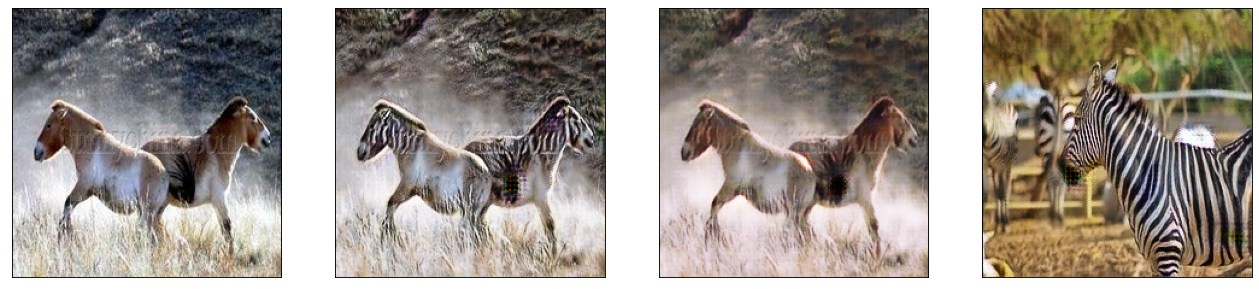

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


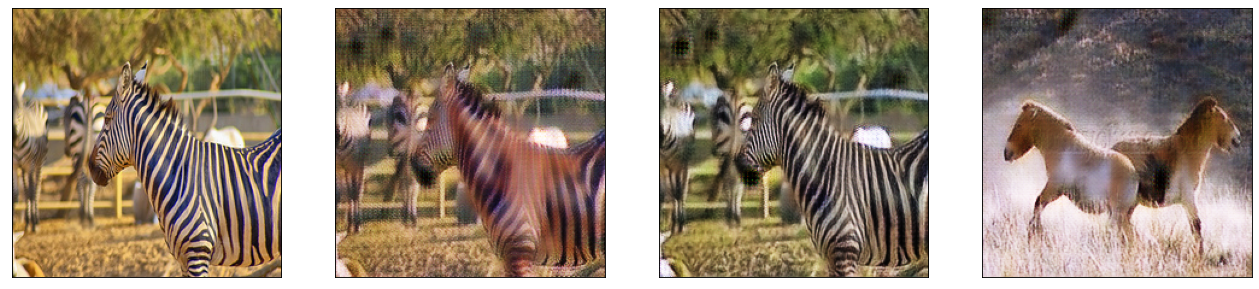

learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
[20000] DA: 0.034294352 0.25298762 0.027597707 DB: 0.14029266 0.023004565 0.045584142 G: 8.848089 2022-05-13 17:02:56
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


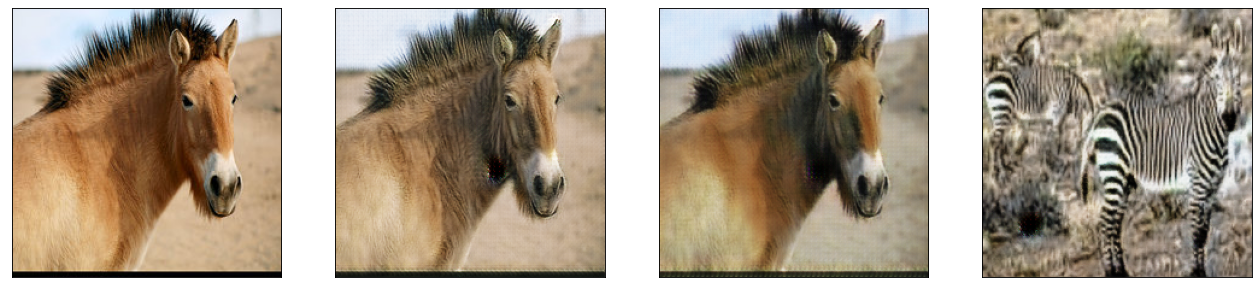

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


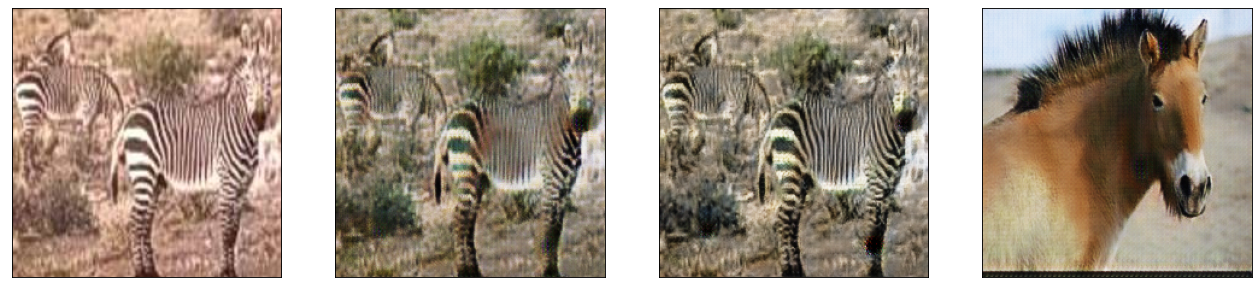

learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
[30000] DA: 0.40228298 0.21379559 0.26591367 DB: 0.23985463 0.73917055 0.065395415 G: 4.8616943 2022-05-13 17:32:51
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


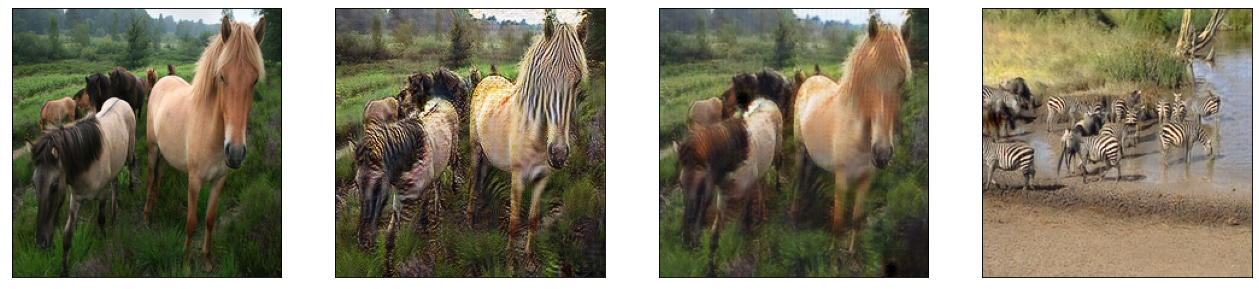

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


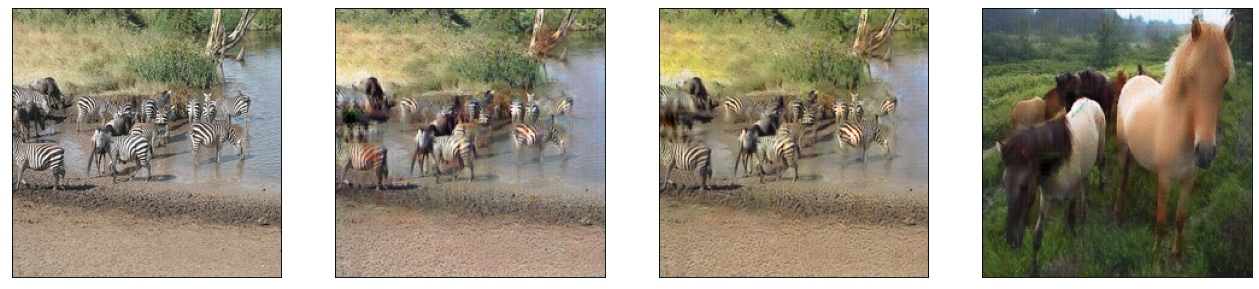

learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000
learning rate 0.0002000 -> 0.0002000


In [ ]:
train(device)